use gpu for training
step:0, recons_loss:0.47692349553108215, g_loss:0.7567696571350098, d_loss:1.388616919517517, real_loss:0.7337242364883423, fake_loss:0.6548926830291748
step:50, recons_loss:0.15039825439453125, g_loss:1.2252366542816162, d_loss:1.271864414215088, real_loss:0.8820997476577759, fake_loss:0.38976460695266724
step:100, recons_loss:0.1607159525156021, g_loss:0.8029197454452515, d_loss:1.4087567329406738, real_loss:0.8073253035545349, fake_loss:0.6014313697814941
step:150, recons_loss:0.15173742175102234, g_loss:0.7820611596107483, d_loss:1.395863652229309, real_loss:0.7708578109741211, fake_loss:0.625005841255188
step:200, recons_loss:0.1577267348766327, g_loss:0.7520525455474854, d_loss:1.359360933303833, real_loss:0.7130785584449768, fake_loss:0.646282434463501
step:250, recons_loss:0.15851134061813354, g_loss:0.8254333138465881, d_loss:1.2825627326965332, real_loss:0.6944948434829712, fake_loss:0.5880679488182068
step:300, recons_loss:0.16774433851242065, g_loss:0.6

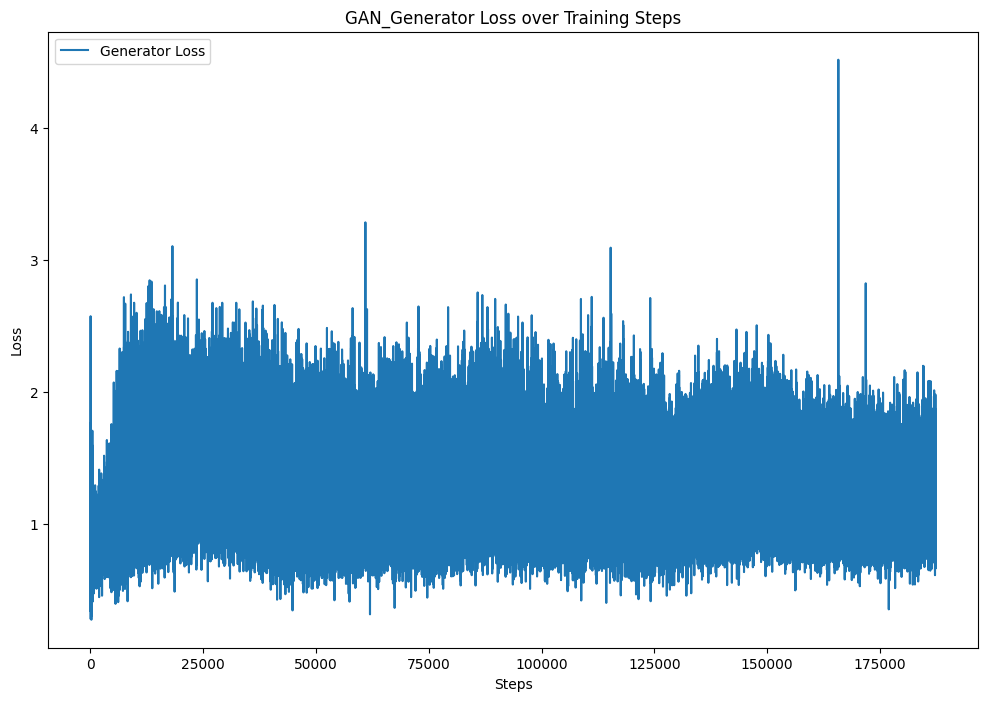

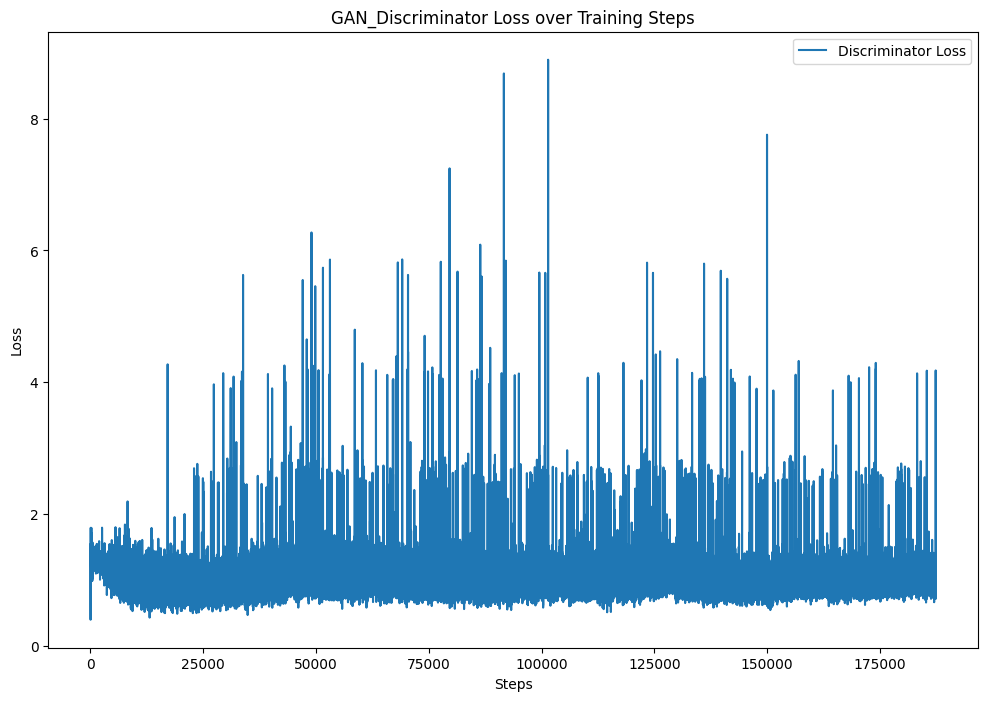

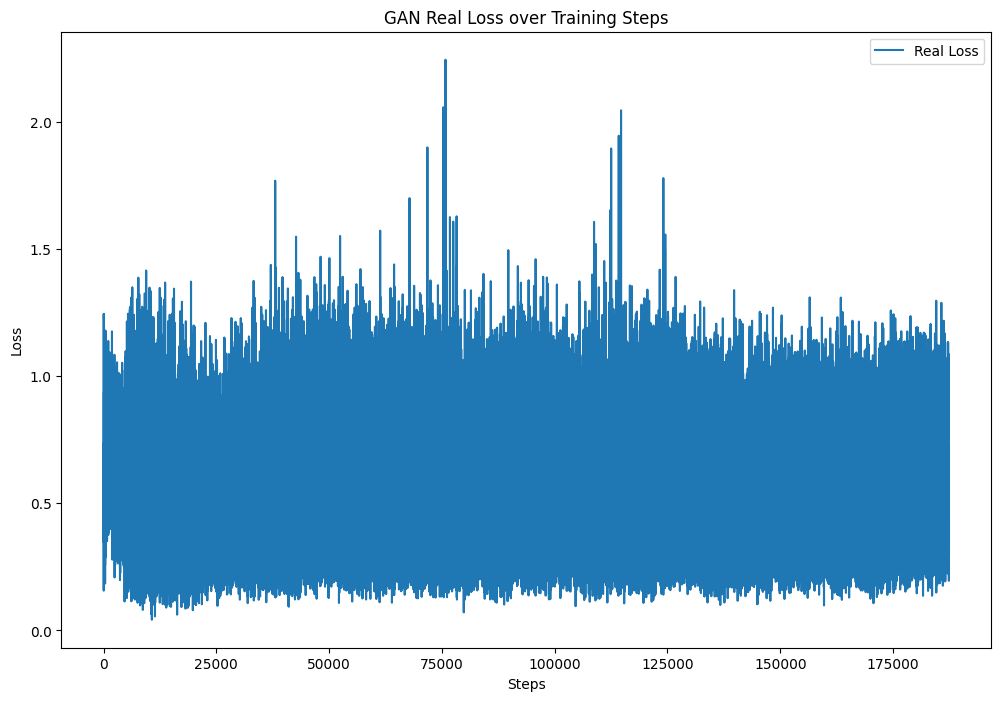

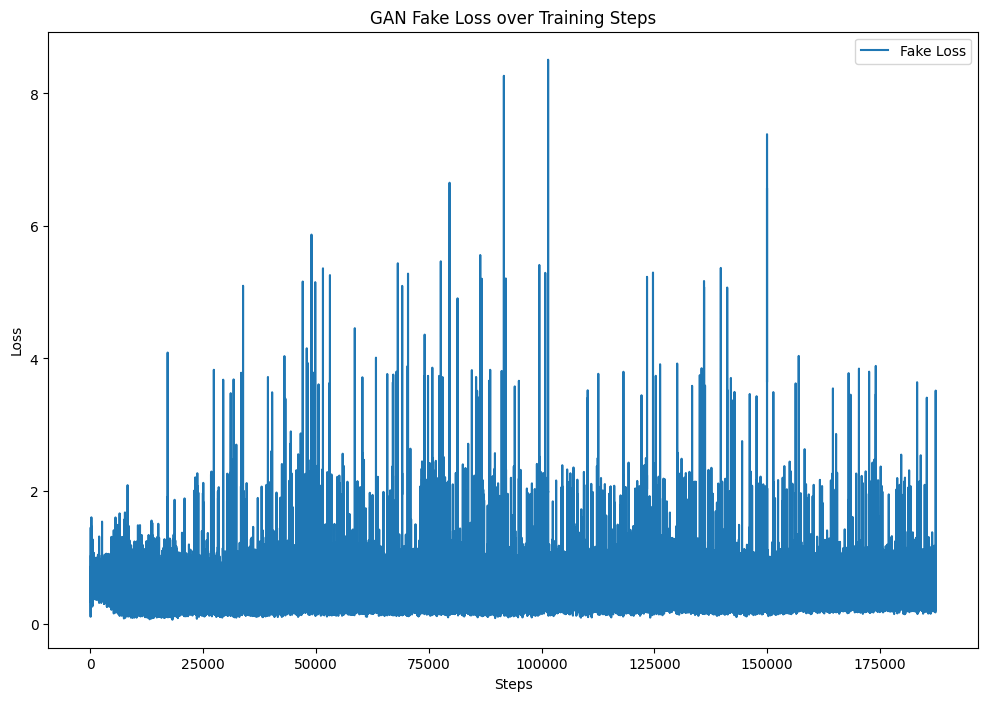

In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

image_size = [1, 28, 28]
latent_dim = 96
batch_size = 64
use_gpu = torch.cuda.is_available()

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.GELU(),

            nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.GELU(),
            nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.GELU(),
            nn.Linear(512, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.GELU(),
            nn.Linear(1024, np.prod(image_size, dtype=np.int32)),
            nn.Sigmoid(),
        )

    def forward(self, z):
        output = self.model(z)
        image = output.reshape(z.shape[0], *image_size)
        return image


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(np.prod(image_size, dtype=np.int32), 512),
            torch.nn.GELU(),
            nn.Linear(512, 256),
            torch.nn.GELU(),
            nn.Linear(256, 128),
            torch.nn.GELU(),
            nn.Linear(128, 64),
            torch.nn.GELU(),
            nn.Linear(64, 32),
            torch.nn.GELU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, image):
        return self.model(image.reshape(image.shape[0], -1))

# Training
dataset = torchvision.datasets.MNIST("mnist_data", train=True, download=True,
                                     transform=torchvision.transforms.Compose(
                                         [
                                             torchvision.transforms.Resize(28),
                                             torchvision.transforms.ToTensor(),
                                         ]
                                     )
                                     )

# Use only 10% of the dataset
subset_size = len(dataset)
subset, _ = torch.utils.data.random_split(dataset, [subset_size, len(dataset) - subset_size])

dataloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, drop_last=True)

generator = Generator()
discriminator = Discriminator()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)

loss_fn = nn.BCELoss()
labels_one = torch.ones(batch_size, 1)
labels_zero = torch.zeros(batch_size, 1)

if use_gpu:
    print("use gpu for training")
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    loss_fn = loss_fn.cuda()
    labels_one = labels_one.to("cuda")
    labels_zero = labels_zero.to("cuda")

num_epoch = 200
g_losses = []
d_losses = []
real_losses = []
fake_losses = []

for epoch in range(num_epoch):
    for i, mini_batch in enumerate(dataloader):
        gt_images, _ = mini_batch

        z = torch.randn(batch_size, latent_dim)

        if use_gpu:
            gt_images = gt_images.to("cuda")
            z = z.to("cuda")

        pred_images = generator(z)
        g_optimizer.zero_grad()

        recons_loss = torch.abs(pred_images - gt_images).mean()

        g_loss = recons_loss * 0.05 + loss_fn(discriminator(pred_images), labels_one)

        g_loss.backward()
        g_optimizer.step()

        d_optimizer.zero_grad()

        real_loss = loss_fn(discriminator(gt_images), labels_one)
        fake_loss = loss_fn(discriminator(pred_images.detach()), labels_zero)
        d_loss = (real_loss + fake_loss)

        d_loss.backward()
        d_optimizer.step()

        if i % 50 == 0:
            print(f"step:{len(dataloader) * epoch + i}, recons_loss:{recons_loss.item()}, g_loss:{g_loss.item()}, d_loss:{d_loss.item()}, real_loss:{real_loss.item()}, fake_loss:{fake_loss.item()}")

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        real_losses.append(real_loss.item())
        fake_losses.append(fake_loss.item())
# Plotting the losses
steps = np.arange(len(g_losses))

plt.figure(figsize=(12, 8))
plt.plot(steps, g_losses, label='Generator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN_Generator Loss over Training Steps')
plt.savefig('GAN_generator_loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(steps, d_losses, label='Discriminator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN_Discriminator Loss over Training Steps')
plt.savefig('GAN_discriminator_loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(steps, real_losses, label='Real Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Real Loss over Training Steps')
plt.savefig('GAN_real_loss.png')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(steps, fake_losses, label='Fake Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Fake Loss over Training Steps')
plt.savefig('GAN_Fake_loss.png')
plt.show()